# 0. Install and Import Dependencies

In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.4
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.2.1
altair                           4.2.2
anyio                            3.7.0
appdirs                          1.4.4
argon2-cffi                      21.3.0
argon2-cffi-bindings             21.2.0
array-record                     0.4.0
arviz                            0.15.1
astropy                          5.2.2
astunparse                       1.6.3
async-timeout                    4.0.2
attrs                            23.1.0
audioread                        3.0.0
autograd                         1.6
Babel                            2.12.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bleach                           6.0.0
blis                             0.7.9
bl

In [ ]:
!pip install opencv-python matplotlib imageio gdown tensorflow==2.10.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [ ]:
import gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
To: /content/data.zip
100%|██████████| 423M/423M [00:03<00:00, 129MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/data'

In [ ]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [ ]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [ ]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [ ]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [ ]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [ ]:
test_path = '/content/drive/MyDrive/data/s1/bbaf2n.mpg'

In [ ]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbaf2n'

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

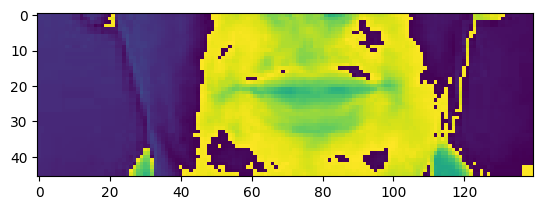

In [ ]:
plt.imshow(frames[40])

In [ ]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23])>

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

In [ ]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
data = tf.data.Dataset.list_files('/content/drive/MyDrive/data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [ ]:
len(test)

50

In [ ]:
frames, alignments = data.as_numpy_iterator().next()

In [ ]:
len(frames)

2

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
val = sample.next(); val[0]

array([[[[[ 1.5136974 ],
          [ 1.5136974 ],
          [ 1.4340291 ],
          ...,
          [ 0.03983414],
          [ 0.03983414],
          [ 0.03983414]],

         [[ 1.5136974 ],
          [ 1.5136974 ],
          [ 1.4340291 ],
          ...,
          [ 0.03983414],
          [ 0.03983414],
          [ 0.03983414]],

         [[ 1.394195  ],
          [ 1.394195  ],
          [ 1.394195  ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         ...,

         [[ 0.9560194 ],
          [ 0.9560194 ],
          [ 0.9560194 ],
          ...,
          [ 9.918701  ],
          [ 9.918701  ],
          [ 9.918701  ]],

         [[ 0.9560194 ],
          [ 0.9560194 ],
          [ 0.9560194 ],
          ...,
          [ 9.878867  ],
          [ 9.878867  ],
          [ 9.878867  ]],

         [[ 0.9560194 ],
          [ 0.9560194 ],
          [ 0.9560194 ],
          ...,
          [ 9.878867  ],
          [ 9.878867  ],
          

In [ ]:
imageio.mimsave('/content/drive/MyDrive/data/animation.gif', val[0][0], fps=10)

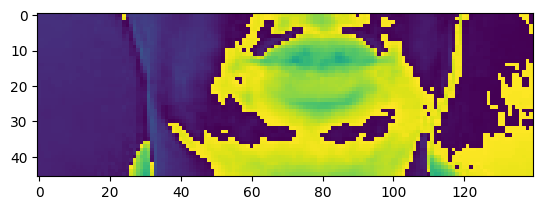

In [ ]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at m two now'>

# 3. Design the Deep Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [ ]:
# Model architecture
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [ ]:
yhat = model.predict(val[0])

1/1 [==============================] - 8s 8s/step


In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'777777777777777777777777777777777777777777777777777777777777777777777777lll'>

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'777777777777777777777777777777777777777777777777777777777777777777777777lll'>

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
# Register the custom loss function
custom_objects = {'CTCLoss': CTCLoss}

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model = load_model('/content/drive/MyDrive/Model_Lip/checkpoint.h5', custom_objects=custom_objects)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint('/content/drive/MyDrive/Model_Lip/checkpoint2.h5', monitor='val_loss', save_weights_only=False)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [ ]:
history = model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, early_stopping])

Epoch 1/100
450/450 [==============================] - 632s 1s/step - loss: 2.0605 - val_loss: 1.0305
Epoch 2/100
450/450 [==============================] - 629s 1s/step - loss: 2.0845 - val_loss: 0.6975
Epoch 3/100
450/450 [==============================] - 629s 1s/step - loss: 1.8581 - val_loss: 0.5743
Epoch 4/100
450/450 [==============================] - 629s 1s/step - loss: 2.0910 - val_loss: 0.6202
Epoch 5/100
450/450 [==============================] - 628s 1s/step - loss: 1.8088 - val_loss: 1.1570
Epoch 5: early stopping


In [ ]:
# Menyimpan bobot model ke dalam format .h5
model.save('/content/drive/MyDrive/Model_Lip/models5.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/Model_Lip/checkpoint2.h5', custom_objects=custom_objects)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint('/content/drive/MyDrive/Model_Lip/checkpoint3.h5', monitor='val_loss', save_weights_only=False)

In [ ]:
history = model.fit(train, validation_data=test, epochs=10, callbacks=[checkpoint_callback, early_stopping])

Epoch 1/10
450/450 [==============================] - 637s 1s/step - loss: 1.7159 - val_loss: 0.7562
Epoch 2/10
450/450 [==============================] - 627s 1s/step - loss: 1.6604 - val_loss: 0.7365
Epoch 3/10
450/450 [==============================] - 628s 1s/step - loss: 1.4941 - val_loss: 0.4381
Epoch 4/10
450/450 [==============================] - 627s 1s/step - loss: 1.4789 - val_loss: 0.7722
Epoch 5/10
450/450 [==============================] - 628s 1s/step - loss: 1.2805 - val_loss: 0.4166
Epoch 6/10
450/450 [==============================] - 629s 1s/step - loss: 1.7086 - val_loss: 0.5593
Epoch 7/10
450/450 [==============================] - 632s 1s/step - loss: 1.3726 - val_loss: 0.4622
Epoch 7: early stopping


In [ ]:
# Menyimpan bobot model ke dalam format .h5
model.save('/content/drive/MyDrive/Model_Lip/models6.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/Model_Lip/checkpoint3.h5', custom_objects=custom_objects)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint('/content/drive/MyDrive/Model_Lip/checkpoint4.h5', monitor='val_loss', save_weights_only=False)

In [ ]:
history = model.fit(train, validation_data=test, epochs=10, callbacks=[checkpoint_callback, early_stopping])

Epoch 1/10
450/450 [==============================] - 643s 1s/step - loss: 1.1991 - val_loss: 0.5363
Epoch 2/10
450/450 [==============================] - 630s 1s/step - loss: 1.1792 - val_loss: 0.6925
Epoch 3/10
450/450 [==============================] - 629s 1s/step - loss: 1.2105 - val_loss: 0.3478
Epoch 4/10
450/450 [==============================] - 632s 1s/step - loss: 1.1173 - val_loss: 0.8188
Epoch 5/10
450/450 [==============================] - 630s 1s/step - loss: 1.3909 - val_loss: 0.5130
Epoch 5: early stopping


In [ ]:
# Menyimpan bobot model ke dalam format .h5
model.save('/content/drive/MyDrive/Model_Lip/models7.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/Model_Lip/checkpoint4.h5', custom_objects=custom_objects)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint('/content/drive/MyDrive/Model_Lip/checkpoint5.h5', monitor='val_loss', save_weights_only=False)

In [ ]:
history = model.fit(train, validation_data=test, epochs=10, callbacks=[checkpoint_callback, early_stopping])

Epoch 1/10
450/450 [==============================] - 642s 1s/step - loss: 1.1309 - val_loss: 0.1886
Epoch 2/10
450/450 [==============================] - 625s 1s/step - loss: 0.9690 - val_loss: 0.2122
Epoch 3/10
450/450 [==============================] - 626s 1s/step - loss: 0.9584 - val_loss: 0.2679
Epoch 3: early stopping


In [ ]:
# Menyimpan bobot model ke dalam format .h5
model.save('/content/drive/MyDrive/Model_Lip/models8.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/Model_Lip/checkpoint5.h5', custom_objects=custom_objects)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint('/content/drive/MyDrive/Model_Lip/checkpoint6.h5', monitor='val_loss', save_weights_only=False)

In [ ]:
history = model.fit(train, validation_data=test, epochs=10, callbacks=[checkpoint_callback, early_stopping])

Epoch 1/10
450/450 [==============================] - 688s 1s/step - loss: 0.9042 - val_loss: 0.4243
Epoch 2/10
450/450 [==============================] - 671s 1s/step - loss: 0.8893 - val_loss: 0.5247
Epoch 3/10
450/450 [==============================] - 675s 2s/step - loss: 0.9469 - val_loss: 0.1985
Epoch 4/10
450/450 [==============================] - 675s 2s/step - loss: 0.8715 - val_loss: 0.2158
Epoch 5/10
450/450 [==============================] - 676s 2s/step - loss: 1.1501 - val_loss: 0.4593
Epoch 5: early stopping


In [ ]:
# Menyimpan bobot model ke dalam format .h5
model.save('/content/drive/MyDrive/Model_Lip/models9.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/Model_Lip/checkpoint6.h5', custom_objects=custom_objects)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint('/content/drive/MyDrive/Model_Lip/checkpoint7.h5', monitor='val_loss', save_weights_only=False)

In [ ]:
history = model.fit(train, validation_data=test, epochs=10, callbacks=[checkpoint_callback, early_stopping])

Epoch 1/10
450/450 [==============================] - 685s 2s/step - loss: 0.8564 - val_loss: 0.1894
Epoch 2/10
450/450 [==============================] - 671s 1s/step - loss: 0.7948 - val_loss: 0.2804
Epoch 3/10
450/450 [==============================] - 665s 1s/step - loss: 1.0637 - val_loss: 0.8553
Epoch 3: early stopping


In [ ]:
# Menyimpan bobot model ke dalam format .h5
model.save('/content/drive/MyDrive/Model_Lip/models10.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/Model_Lip/checkpoint7.h5', custom_objects=custom_objects)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint('/content/drive/MyDrive/Model_Lip/checkpoint8.h5', monitor='val_loss', save_weights_only=False)

In [ ]:
history = model.fit(train, validation_data=test, epochs=10, callbacks=[checkpoint_callback])

Epoch 1/10
450/450 [==============================] - 651s 1s/step - loss: 0.8496 - val_loss: 0.1770
Epoch 2/10
450/450 [==============================] - 629s 1s/step - loss: 0.7461 - val_loss: 0.3053
Epoch 3/10
450/450 [==============================] - 631s 1s/step - loss: 0.6766 - val_loss: 0.2401
Epoch 4/10
450/450 [==============================] - 632s 1s/step - loss: 0.8042 - val_loss: 0.2619
Epoch 5/10
450/450 [==============================] - 635s 1s/step - loss: 0.8783 - val_loss: 0.1906
Epoch 6/10
450/450 [==============================] - 640s 1s/step - loss: 0.8072 - val_loss: 0.1390
Epoch 7/10
450/450 [==============================] - 652s 1s/step - loss: 0.6185 - val_loss: 0.2816
Epoch 8/10
450/450 [==============================] - 650s 1s/step - loss: 0.5200 - val_loss: 0.1832
Epoch 9/10
450/450 [==============================] - 644s 1s/step - loss: 0.6489 - val_loss: 0.0932
Epoch 10/10
450/450 [==============================] - 640s 1s/step - loss: 0.5885 - val_lo

In [ ]:
# Menyimpan bobot model ke dalam format .h5
model.save('/content/drive/MyDrive/Model_Lip/models11.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/Model_Lip/checkpoint8.h5', custom_objects=custom_objects)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint('/content/drive/MyDrive/Model_Lip/checkpoint9.h5', monitor='val_loss', save_weights_only=False)

In [ ]:
history = model.fit(train, validation_data=test, epochs=10, callbacks=[checkpoint_callback])

Epoch 1/10
450/450 [==============================] - 653s 1s/step - loss: 0.5294 - val_loss: 0.1609
Epoch 2/10
450/450 [==============================] - 630s 1s/step - loss: 0.5058 - val_loss: 0.1160
Epoch 3/10
450/450 [==============================] - 630s 1s/step - loss: 0.8951 - val_loss: 0.3379
Epoch 4/10
450/450 [==============================] - 631s 1s/step - loss: 0.7575 - val_loss: 0.4517
Epoch 5/10
450/450 [==============================] - 630s 1s/step - loss: 0.4956 - val_loss: 0.0878
Epoch 6/10
450/450 [==============================] - 629s 1s/step - loss: 0.4203 - val_loss: 0.0966
Epoch 7/10
450/450 [==============================] - 629s 1s/step - loss: 0.4275 - val_loss: 0.0409
Epoch 8/10
450/450 [==============================] - 629s 1s/step - loss: 0.4247 - val_loss: 0.0858
Epoch 9/10
450/450 [==============================] - 627s 1s/step - loss: 0.6157 - val_loss: 0.1609
Epoch 10/10
450/450 [==============================] - 628s 1s/step - loss: 0.5248 - val_lo

In [ ]:
# Menyimpan bobot model ke dalam format .h5
model.save('/content/drive/MyDrive/Model_Lip/models12.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/Model_Lip/checkpoint9.h5', custom_objects=custom_objects)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint('/content/drive/MyDrive/Model_Lip/checkpoint10.h5', monitor='val_loss', save_weights_only=False)

In [ ]:
history = model.fit(train, validation_data=test, epochs=10, callbacks=[checkpoint_callback])

Epoch 1/10
450/450 [==============================] - 641s 1s/step - loss: 0.4382 - val_loss: 0.2817
Epoch 2/10
450/450 [==============================] - 632s 1s/step - loss: 0.4881 - val_loss: 0.1228
Epoch 3/10
450/450 [==============================] - 630s 1s/step - loss: 0.4985 - val_loss: 0.0984
Epoch 4/10
450/450 [==============================] - 630s 1s/step - loss: 0.5152 - val_loss: 0.0648
Epoch 5/10
450/450 [==============================] - 632s 1s/step - loss: 0.7888 - val_loss: 0.1426
Epoch 6/10
450/450 [==============================] - 632s 1s/step - loss: 0.4627 - val_loss: 0.0289
Epoch 7/10
450/450 [==============================] - 635s 1s/step - loss: 0.3059 - val_loss: 0.0160
Epoch 8/10
450/450 [==============================] - 633s 1s/step - loss: 0.2635 - val_loss: 0.0254
Epoch 9/10
450/450 [==============================] - 622s 1s/step - loss: 0.3126 - val_loss: 0.0641
Epoch 10/10
450/450 [==============================] - 642s 1s/step - loss: 0.3154 - val_lo

In [ ]:
# Menyimpan bobot model ke dalam format .h5
model.save('/content/drive/MyDrive/Model_Lip/models13.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/Model_Lip/checkpoint10.h5', custom_objects=custom_objects)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint('/content/drive/MyDrive/Model_Lip/checkpoint11.h5', monitor='val_loss', save_weights_only=False)

In [ ]:
history = model.fit(train, validation_data=test, epochs=10, callbacks=[checkpoint_callback])

Epoch 1/10
450/450 [==============================] - 633s 1s/step - loss: 0.4391 - val_loss: 0.1265
Epoch 2/10
450/450 [==============================] - 629s 1s/step - loss: 0.3301 - val_loss: 0.0478
Epoch 3/10
450/450 [==============================] - 629s 1s/step - loss: 0.3551 - val_loss: 0.0342
Epoch 4/10
450/450 [==============================] - 631s 1s/step - loss: 0.4621 - val_loss: 0.3001
Epoch 5/10
450/450 [==============================] - 634s 1s/step - loss: 0.5432 - val_loss: 0.0314
Epoch 6/10
450/450 [==============================] - 631s 1s/step - loss: 0.2944 - val_loss: 0.0409
Epoch 7/10
450/450 [==============================] - 632s 1s/step - loss: 0.2731 - val_loss: 0.2974
Epoch 8/10
450/450 [==============================] - 635s 1s/step - loss: 0.3257 - val_loss: 0.0506
Epoch 9/10
450/450 [==============================] - 631s 1s/step - loss: 0.2837 - val_loss: 0.0149
Epoch 10/10
450/450 [==============================] - 630s 1s/step - loss: 0.3215 - val_lo

In [ ]:
# Menyimpan bobot model ke dalam format .h5
model.save('/content/drive/MyDrive/Model_Lip/models14.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/Model_Lip/checkpoint11.h5', custom_objects=custom_objects)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint('/content/drive/MyDrive/Model_Lip/checkpoint12.h5', monitor='val_loss', save_weights_only=False)

In [ ]:
history = model.fit(train, validation_data=test, epochs=10, callbacks=[checkpoint_callback, early_stopping])

Epoch 1/10
450/450 [==============================] - 636s 1s/step - loss: 0.3170 - val_loss: 0.3513
Epoch 2/10
450/450 [==============================] - 618s 1s/step - loss: 0.3391 - val_loss: 0.0674
Epoch 3/10
450/450 [==============================] - 620s 1s/step - loss: 0.2675 - val_loss: 0.0159
Epoch 4/10
450/450 [==============================] - 621s 1s/step - loss: 0.8129 - val_loss: 0.0205
Epoch 5/10
450/450 [==============================] - 624s 1s/step - loss: 0.3737 - val_loss: 0.0379
Epoch 6/10
450/450 [==============================] - 620s 1s/step - loss: 0.3156 - val_loss: 0.0206
Epoch 7/10
450/450 [==============================] - 622s 1s/step - loss: 0.2505 - val_loss: 0.0181
Epoch 8/10
450/450 [==============================] - 623s 1s/step - loss: 0.2044 - val_loss: 0.1306
Epoch 8: early stopping


In [ ]:
# Menyimpan bobot model ke dalam format .h5
model.save('/content/drive/MyDrive/Model_Lip/models15.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/Model_Lip/checkpoint12.h5', custom_objects=custom_objects)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint('/content/drive/MyDrive/Model_Lip/checkpoint13.h5', monitor='val_loss', save_weights_only=False)

In [ ]:
history = model.fit(train, validation_data=test, epochs=10, callbacks=[checkpoint_callback, early_stopping])

Epoch 1/10
450/450 [==============================] - 655s 1s/step - loss: 0.2326 - val_loss: 0.2198
Epoch 2/10
450/450 [==============================] - 635s 1s/step - loss: 0.2905 - val_loss: 0.4693
Epoch 3/10
450/450 [==============================] - 637s 1s/step - loss: 0.3089 - val_loss: 0.3429
Epoch 4/10
450/450 [==============================] - 632s 1s/step - loss: 0.3987 - val_loss: 0.1261
Epoch 5/10
450/450 [==============================] - 632s 1s/step - loss: 0.3447 - val_loss: 0.0159
Epoch 6/10
450/450 [==============================] - 630s 1s/step - loss: 0.2293 - val_loss: 0.0114
Epoch 7/10
450/450 [==============================] - 630s 1s/step - loss: 0.5050 - val_loss: 0.0251
Epoch 8/10
450/450 [==============================] - 632s 1s/step - loss: 0.3163 - val_loss: 0.0361
Epoch 9/10
450/450 [==============================] - 634s 1s/step - loss: 0.2820 - val_loss: 0.0140
Epoch 10/10
450/450 [==============================] - 631s 1s/step - loss: 0.2347 - val_lo

In [ ]:
# Menyimpan bobot model ke dalam format .h5
model.save('/content/drive/MyDrive/Model_Lip/models16.h5')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Model_Lip/models2.h5', custom_objects={'CTCLoss': CTCLoss})

In [ ]:
num_epochs = 10  # Jumlah epoch baru yang ingin dilatih


In [ ]:
model.fit(train, validation_data=test, epochs=num_epochs, callbacks=[checkpoint_callback, early_stopping])


Epoch 1/10
450/450 [==============================] - 693s 2s/step - loss: 7.8370 - val_loss: 4.5387
Epoch 2/10
450/450 [==============================] - 689s 2s/step - loss: 7.0859 - val_loss: 4.4164
Epoch 3/10
450/450 [==============================] - 700s 2s/step - loss: 6.7297 - val_loss: 3.6812
Epoch 4/10
450/450 [==============================] - 691s 2s/step - loss: 6.4208 - val_loss: 3.3546
Epoch 5/10
450/450 [==============================] - 697s 2s/step - loss: 6.0202 - val_loss: 3.2968
Epoch 6/10
450/450 [==============================] - 688s 2s/step - loss: 5.6205 - val_loss: 2.8869
Epoch 7/10
450/450 [==============================] - 688s 2s/step - loss: 5.3537 - val_loss: 2.5566
Epoch 8/10
450/450 [==============================] - 692s 2s/step - loss: 4.9008 - val_loss: 2.3846
Epoch 9/10
450/450 [==============================] - 690s 2s/step - loss: 4.6671 - val_loss: 2.3306
Epoch 10/10
450/450 [==============================] - 688s 2s/step - loss: 4.4753 - val_lo

In [ ]:
# Menyimpan bobot model ke dalam format .h5
model.save('/content/drive/MyDrive/Model_Lip/models3.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/Model_Lip/models3.h5', custom_objects={'CTCLoss': CTCLoss})

In [ ]:
model.fit(train, validation_data=test, epochs=10, callbacks=[checkpoint_callback, early_stopping])

Epoch 1/10
450/450 [==============================] - 706s 2s/step - loss: 3.4755 - val_loss: 1.4336
Epoch 2/10
450/450 [==============================] - 708s 2s/step - loss: 3.2767 - val_loss: 1.4333
Epoch 3/10
450/450 [==============================] - 709s 2s/step - loss: 3.2977 - val_loss: 1.9874
Epoch 4/10
450/450 [==============================] - 702s 2s/step - loss: 3.2172 - val_loss: 0.9992
Epoch 5/10
450/450 [==============================] - 711s 2s/step - loss: 2.8566 - val_loss: 1.2190
Epoch 6/10
450/450 [==============================] - 701s 2s/step - loss: 2.5525 - val_loss: 0.9522
Epoch 7/10
450/450 [==============================] - 689s 2s/step - loss: 2.4145 - val_loss: 0.8537
Epoch 8/10
450/450 [==============================] - 692s 2s/step - loss: 2.4311 - val_loss: 1.2479
Epoch 9/10
450/450 [==============================] - 695s 2s/step - loss: 2.2687 - val_loss: 0.8967
Epoch 9: early stopping


In [ ]:
# Menyimpan bobot model ke dalam format .h5
model.save('/content/drive/MyDrive/Model_Lip/models4.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/Model_Lip/models4.h5', custom_objects={'CTCLoss': CTCLoss})

In [ ]:
model.fit(train, validation_data=test, epochs=10, callbacks=[checkpoint_callback, early_stopping])

Epoch 1/10
450/450 [==============================] - 668s 1s/step - loss: 2.0563 - val_loss: 0.7802
Epoch 2/10
450/450 [==============================] - 662s 1s/step - loss: 1.8924 - val_loss: 0.8994
Epoch 3/10
450/450 [==============================] - 668s 1s/step - loss: 1.9647 - val_loss: 0.6173
Epoch 4/10
450/450 [==============================] - 670s 1s/step - loss: 1.7735 - val_loss: 0.9340
Epoch 5/10
450/450 [==============================] - 666s 1s/step - loss: 1.7653 - val_loss: 0.4606
Epoch 6/10
450/450 [==============================] - 676s 2s/step - loss: 1.7456 - val_loss: 0.9526
Epoch 7/10
450/450 [==============================] - 663s 1s/step - loss: 1.5780 - val_loss: 0.5585
Epoch 7: early stopping


In [ ]:
# Menyimpan bobot model ke dalam format .h5
model.save('/content/drive/MyDrive/Model_Lip/models.h5')

# 6. Accuraccy

In [ ]:
pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.1 MB/s eta 0:00:00


In [ ]:
import jiwer

In [ ]:
# Load the best model
best_model = tf.keras.models.load_model('/content/drive/MyDrive/Model_Lip/models16.h5', custom_objects={'CTCLoss': CTCLoss})

In [ ]:
# Initialize empty lists to store true and predicted labels
true_labels_best = []
predicted_labels_best = []

In [ ]:
# Obtain true and predicted labels using the best model
for data_batch in test:
    true_batch = data_batch[1]
    predicted_batch = best_model.predict(data_batch[0])
    input_length = np.ones(predicted_batch.shape[0]) * predicted_batch.shape[1]  # Set sequence length for each batch
    decoded_batch = tf.keras.backend.ctc_decode(predicted_batch, input_length=input_length, greedy=True)[0][0].numpy()

    true_labels_best.extend([tf.strings.reduce_join([num_to_char(word) for word in sentence]).numpy().decode('utf-8') for sentence in true_batch])
    predicted_labels_best.extend([tf.strings.reduce_join([num_to_char(word) for word in sentence]).numpy().decode('utf-8') for sentence in decoded_batch])

1/1 [==============================] - 0s 167ms/step


In [ ]:
# Calculate accuracy
correct_predictions = sum(1 for true, predicted in zip(true_labels_best, predicted_labels_best) if true == predicted)
total_samples = len(true_labels_best)
accuracy = correct_predictions / total_samples

In [ ]:
# Calculate Word Error Rate (WER)
wer = jiwer.wer(true_labels_best, predicted_labels_best)

In [ ]:
print("Akurasi multikelas: {:.2f}%".format(accuracy * 100))
print("Word Error Rate (WER):", wer)

Akurasi multikelas: 100.00%
Word Error Rate (WER): 0.0


# Pecision, Recall, F1-Score

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
# Calculate precision, recall, and f1-score
precision = precision_score(true_labels_best, predicted_labels_best, average='weighted')
recall = recall_score(true_labels_best, predicted_labels_best, average='weighted')
f1 = f1_score(true_labels_best, predicted_labels_best, average='weighted')

In [ ]:
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 1.0
Recall: 1.0
F1-score: 1.0



# 7. Make a Prediction

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From: https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:02<00:00, 40.3MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [ ]:
model.load_weights('/content/drive/MyDrive/Model_Lip/models16.h5')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

1/1 [==============================] - 0s 275ms/step


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place red in c three soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin green at h three again'>]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place red in c three soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin green at h three again'>]

# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('/content/drive/MyDrive/data/s1/pgik1a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place green in k one again'>]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 983ms/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place green in k one again'>]

# 8. Convert TFLite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)


In [ ]:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

In [ ]:
tflite_model = converter.convert()


In [ ]:
tflite_model_path = '/content/drive/MyDrive/Model_Lip/Best_Model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)
